In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage import data, color, img_as_float, img_as_ubyte, filters, feature, io

%matplotlib inline
from IPython.display import HTML, display

# Image filters and feature detection

In this lab, we will implement some simple solution to perform features detection on images. First of all, what does it mean **feature detection**?

*In computer vision and image processing the concept of feature detection refers to methods that aim at computing abstractions of image information and making local decisions at every image point whether there is an image feature of a given type at that point or not. The resulting features will be subsets of the image domain, often in the form of isolated points, continuous curves or connected regions.*

[cit. <a href="https://en.wikipedia.org/wiki/Feature_detection_(computer_vision)">Wikipedia</a>]

In this lab we will restrict our attention on **edges** and **corners** (see example below). For a comprehensive summary on feature detection algorithms, I strongly recommend to check <a href="http://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=feature#module-skimage.feature">`skimage.feature`</a> API.

## 1. Edge detection

Over the years, <a href="https://en.wikipedia.org/wiki/Edge_detection">several algorithms</a> for edge detection were developed. In this lab we are going to implement an edge detector that follows this simple strategy:

1. perform Gaussian smoothing on an input greyscale image;
2. then compute the partial first derivatives on the result and the magnitude of the gradient;
4. thresholds the magnitude of the gradient with an input threshold;
5. return the edge map.

The parameters of every intermediate step, must be specified as input arguments.

### 1.1 Gaussian smoothing
We already covered this step in the last lab.

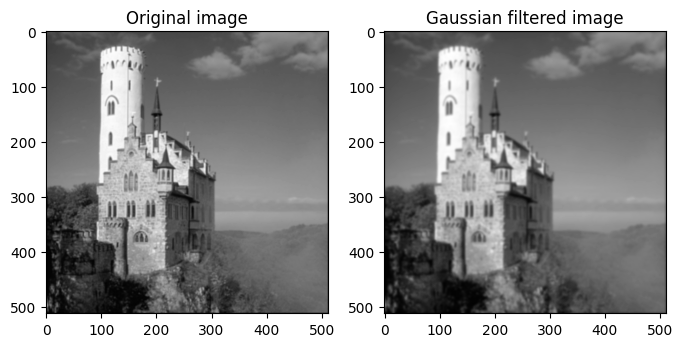

In [7]:
# Load an input image and convert it to grayscale
original_img = io.imread('/content/drive/MyDrive/DLCV2024_for_students/labs/image_features/data/images/castle.png')



# check if image is rgb or already in greyscale, convert to greyscale(in case its RGB),
# in both cases convert image to float
if(len(original_img.shape)==3):
    img_grey = img_as_float(color.rgb2gray(original_img))
elif(len(original_img.shape)==2):
    img_grey = img_as_float(original_img)

# Apply gaussian filter
sigma = np.sqrt(2) # TRY WITH OTHER VALUES!
img_smooth = filters.gaussian(img_grey, sigma)

plt.figure(figsize=(8,6))
plt.subplot(121)
plt.imshow(original_img, cmap=cm.gist_gray)
plt.title('Original image')
plt.subplot(122)
plt.imshow(img_smooth, cmap=cm.gist_gray)
plt.title('Gaussian filtered image');

### 1.2 Image gradient
To estimate the first derivative (finite differences) of an image on the horizontal ($I_x$) direction you can simply perform a convolution of the image with the kernel $k=[-0.5, 0, 0.5]$. Can you guess what do you need to do to estimate the first derivative on the vertical ($I_y$) direction?

The magnitude of the gradient is $G = \sqrt{I_x^2+I_y^2}$.

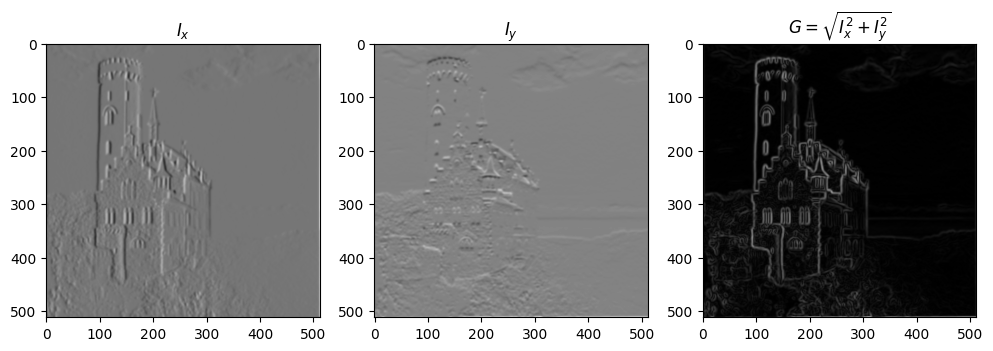

In [8]:
# Partial derivatives kernel
k = np.array([-0.5, 0, 0.5]) #you may also. try [-1,1]

# Compute first derivative along x
Ix = np.zeros_like(img_grey)
for i, r in enumerate(img_smooth):
        Ix[i, :] = signal.convolve(r, k, mode='same')

# Compute first derivative along y
Iy = np.zeros_like(img_grey)
for i, c in enumerate(img_smooth.T):
        Iy[:, i] = signal.convolve(c, k, mode='same')

# Compute the magnitude of the gradient
G = np.sqrt(Ix**2 + Iy**2)


plt.figure(figsize=(12,6))
plt.subplot(131)
plt.imshow(Ix, cmap=cm.gist_gray)
plt.title(r'$I_x$')
plt.subplot(132)
plt.imshow(Iy, cmap=cm.gist_gray)
plt.title(r'$I_y$')
plt.subplot(133)
plt.imshow(G, cmap=cm.gist_gray)
plt.title(r'$G = \sqrt{I_x^2+I_y^2}$')
plt.tight_layout;

### 1.3 Edge map
Thresholding the gradient you should be able to obtain the an estimate of the edges of the input image.

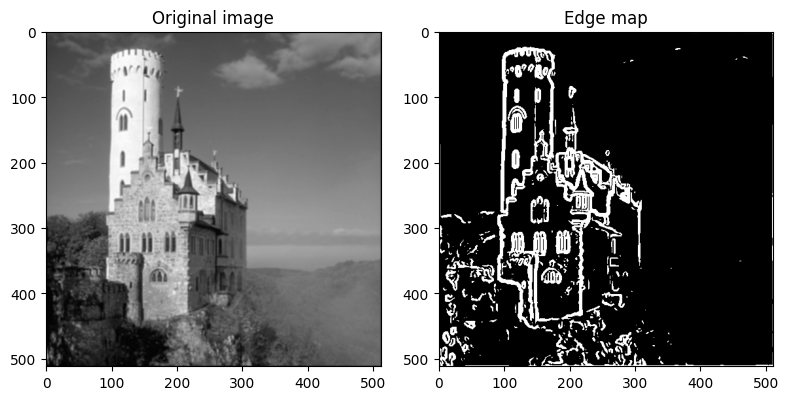

In [9]:
threshold = 0.03
edge = np.where(G > threshold, 1, 0)

plt.figure(figsize=(8,6))
plt.subplot(121)
plt.imshow(original_img, cmap=cm.gist_gray)
plt.title('Original image')
plt.subplot(122)
plt.imshow(edge, cmap=cm.gist_gray)
plt.title('Edge map');
plt.tight_layout()

### 1.4 Edge detection function
Summarize the steps above in a single function named `edge_detector`, and test it to different images.

In [10]:
def edge_detector(img, sigma, threshold):
    """Perform edge detection on an input RGB image.

    - img: (n, m) input RGB image
    - sigma: float, standard deviation of the Gaussian smoothing
    - threshold: float, threshold value for the gradient
    """

    # Apply Gaussian filter
    img_smooth = filters.gaussian(img, sigma)

    # Compute first derivatives with the following kernel
    k = np.array([-0.5, 0, 0.5])

    # Compute first derivative along x
    Ix = np.zeros(img_smooth.shape)
    for i, r in enumerate(img_smooth):

        Ix[i, :] = signal.convolve(r, k, mode='same')

    # Compute first derivative along y
    Iy = np.zeros(img_smooth.shape)
    for i, c in enumerate(img_smooth.T):
        Iy[:, i] = signal.convolve(c, k, mode='same')

    # Compute the mangnitude of the gradient
    G = np.sqrt(Ix**2 + Iy**2)

    # Generate edge map
    edge = np.where(G > threshold, 255, 0)

    return edge

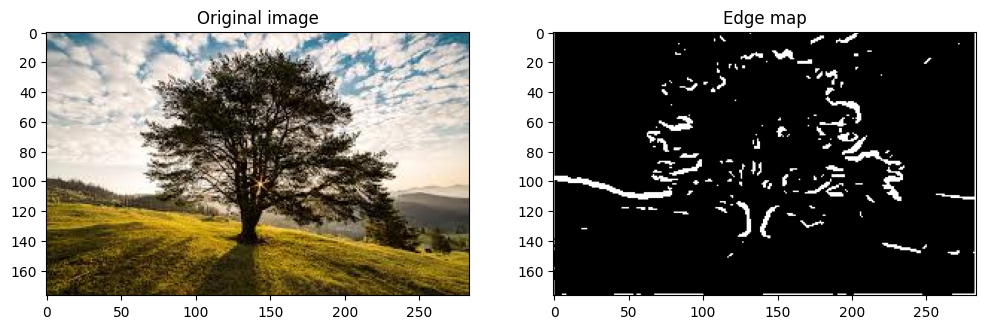

In [ ]:
# Run some edge detection
original_img = io.imread('data/images/tree.jpeg')

# check if image is rgb or already in greyscale, convert to greyscale(in case its RGB),
# in both cases convert image to float

if(len(original_img.shape)==3):
    img_grey = img_as_float(color.rgb2gray(original_img))
elif(len(original_img.shape)==2):
    img_grey = img_as_float(original_img)

edge = edge_detector(img_grey, np.sqrt(2), 0.09)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(original_img, cmap=cm.gist_gray)
plt.title('Original image')
plt.subplot(122)
plt.imshow(edge, cmap=cm.gist_gray)
plt.title('Edge map');

In [ ]:
# FILL IN HERE:
# by appropriate calls of the function above
# COMPARE THE EFFECT OF CHOOSING 3 DIFFERENT THRESHOLDS and 3 DIFFERENT VALUES FOR SIGMA



### 1.5 Comparison with the Canny algorithm
Compare the results obtained by our simple implementation with the well known <a href="http://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=feature#skimage.feature.canny">Canny edge detector</a>.

**Hint:** check the help for `feature.canny` from the `skimage` library

In [ ]:
# get information about canny function
feature.canny??

In [ ]:
# Run some edge detection

original_img = io.imread('data/images/castle.png')



# check if image is rgb or already in greyscale, convert to greyscale(in case its RGB),
# in both cases convert image to float

if(len(original_img.shape)==3):
    img_grey = img_as_float(color.rgb2gray(original_img))
elif(len(original_img.shape)==2):
    img_grey = img_as_float(original_img)


edge = edge_detector(img_grey, np.sqrt(2), 0.09)
edge_canny = feature.canny(# FILL IN HERE )

plt.figure(figsize=(12,6))
plt.subplot(131)
plt.imshow(original_img, cmap=cm.gist_gray)
plt.title('Original image')
plt.subplot(132)
plt.imshow(edge, cmap=cm.gist_gray)
plt.title('Edge map')
plt.subplot(133)
plt.imshow(edge_canny, cmap=cm.gist_gray)
plt.title('Edge map');

SyntaxError: '(' was never closed (336623188.py, line 17)

## 2. Corner detection

Corners are fundamental image features that are often used in a large number of applications such as image matching, object recognition, and so on. Among the <a href="https://en.wikipedia.org/wiki/Corner_detection">plethora of corner detection algorithms</a> a very well known is the <a href="https://en.wikipedia.org/wiki/Corner_detection#The_Harris_.26_Stephens_.2F_Plessey_.2F_Shi.E2.80.93Tomasi_corner_detection_algorithms">Shi-Tomasi</a> algorithm.

For time reasons, istead than our own implementation,  we will exploit directly <a href="http://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=feature#skimage.feature.corner_shi_tomasi">`feature.corner_shi_tomasi`</a> from `skimage` to perform some corner detection.

In [ ]:
feature.corner_shi_tomasi??

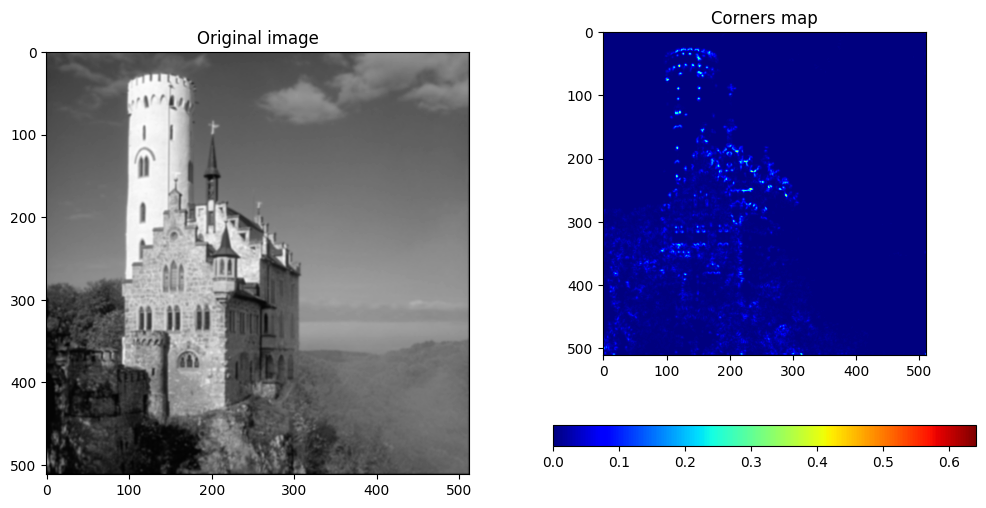

In [ ]:
original_img = io.imread('data/images/castle.png')

# check if image is rgb or already in greyscale, convert to greyscale(in case its RGB),
# in both cases convert image to float

if(len(original_img.shape)==3):
    img_grey = img_as_float(color.rgb2gray(original_img))
elif(len(original_img.shape)==2):
    img_grey = img_as_float(original_img)

corners_map = feature.corner_shi_tomasi(img_grey)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(original_img, cmap=cm.gist_gray)
plt.title('Original image')
plt.subplot(122)
plt.imshow(corners_map, cmap=cm.jet)
plt.colorbar(orientation='horizontal')
plt.title('Corners map');

Once the corner map is estimated, to estimate the actual corner position you should implement some corner peaks detection. A simple idea could be, for instance, to perform a simple thresholding of the corners map. Try this idea out in the next cell.

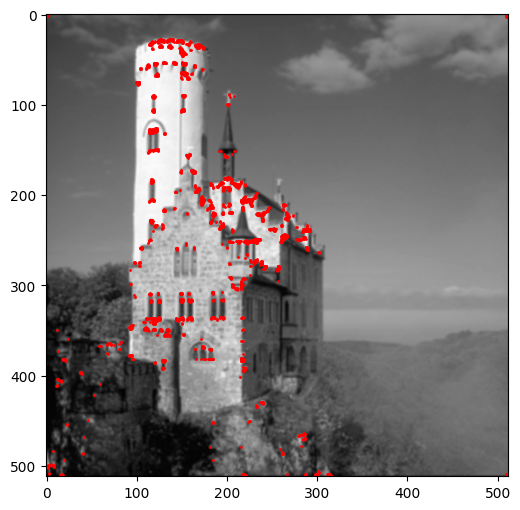

In [ ]:
# FILL IN HERE
# threshold the corner mask

threshold = 0.1
naive_corners = np.where(corners_map > threshold)

plt.figure(figsize=(12,6))
plt.imshow(original_img, cmap=cm.gist_gray)
plt.scatter(naive_corners[1], naive_corners[0], s=1, c='r');

More refined algorithms to detect the corner peaks were proposed, see for instance `feature.corner_peaks`.

In [ ]:
feature.corner_peaks??

Compare the results obtained by the two corner peaks approaches.

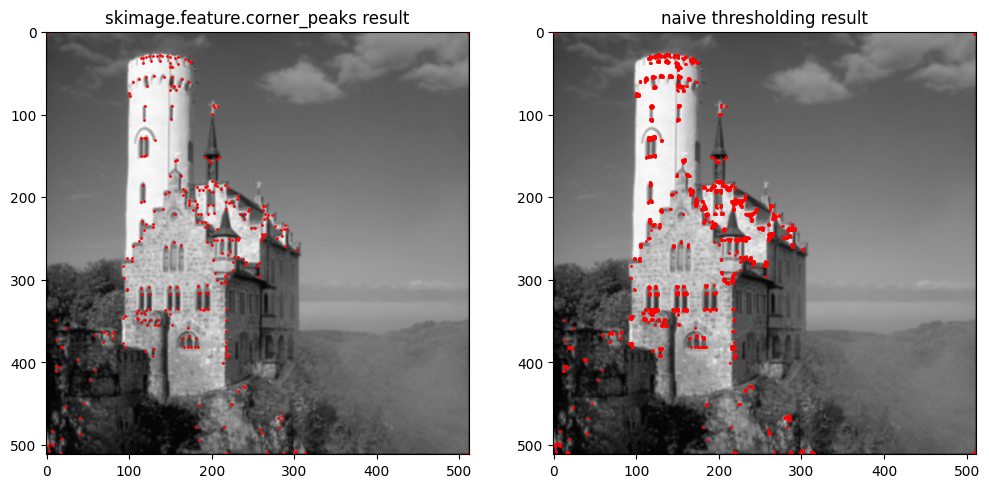

In [ ]:
#original_img = io.imread('castle.png')

# check if image is rgb or already in greyscale, convert to greyscale(in case its RGB),
# in both cases convert image to float

if(len(original_img.shape)==3):
    img_grey = color.rgb2gray(original_img)
elif(len(original_img.shape)==2):
    img_grey = original_img




corners = feature.corner_peaks(feature.corner_shi_tomasi(img_grey),threshold_abs=0.1)


plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(original_img, cmap=cm.gist_gray)
plt.scatter(corners[:,1], corners[:,0], s=1, c='r')
plt.title('skimage.feature.corner_peaks result')

plt.subplot(122)
plt.imshow(original_img, cmap=cm.gist_gray)
plt.scatter(naive_corners[1], naive_corners[0], s=1, c='r')
plt.title('naive thresholding result');

## 3. Finished already?

If you still have time before the lab is over you can try out different images from the  experiment the effect of geometric transformations (rotation and zoom, for instance) on the feature detection of above.
Check the <a href="https://scikit-image.org/docs/dev/api/skimage.transform.html"> skimage.transform library </a>

In [ ]:
feature.corner_peaks??